In [1]:
import sys
import os

import numpy as np
import cv2
import torch
from torch.utils.data import DataLoader
from torchvision import models
from skimage import io
from skimage.transform import resize

sys.path.insert(0, os.path.abspath('..'))

from src.models.gradcam.grad_cam_pipeline import GradCamPipeline
from src.utils.load_cfg import ConfigLoader
from src.factories import ModelFactory
from src.factories import DatasetFactory
from src.utils.misc import MiscUtils

import matplotlib.pyplot as plt
%matplotlib inline


dataset_cfg = '../configs/dataset_cfgs/epickitchens_short.yaml'
train_cfg = '../configs/train_cfgs/train_san_freeze_short.yaml'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Deprocess data for visualization
def deprocess_rgb(rgb, num_segments):
    rgb = rgb.cpu().numpy()
    assert rgb.shape[0] == 1
    _, _, h, w = rgb.shape
    rgb = rgb.reshape([num_segments, 3, h, w]).transpose(0, 2, 3, 1)
    rgb *= 1  # std
    rgb += np.array([104, 117, 128])  # mean
    rgb = rgb.astype(np.uint8)
    return rgb


def deprocess_spec(spec, num_segments):
    spec = spec.cpu().numpy()
    assert spec.shape[0] == 1
    _, _, h, w = spec.shape
    spec = spec.reshape([num_segments, h, w])
    return spec


def display_input(sample, num_segments):
    # Deprocess inputs
    rgb = deprocess_rgb(sample['RGB'], num_segments)
    spec = deprocess_spec(sample['Spec'], num_segments)

    # Display input RGB
    fig, axes = plt.subplots(1, num_segments, figsize=(10, 5))
    fig.suptitle('='*30+'\n  RGB\n'+'='*30, fontsize=15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_segments):
        axes[i].imshow(cv2.cvtColor(rgb[i], cv2.COLOR_BGR2RGB))
        axes[i].axis('off')

    # Display input Spec
    fig, axes = plt.subplots(1, num_segments, figsize=(10, 5))
    fig.suptitle('='*30+'\n  Spec\n'+'='*30, fontsize=15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_segments):
        axes[i].imshow(spec[i], cmap='viridis')
        axes[i].axis('off')

In [3]:
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

sample_id = 64


def load(model_cfg, dataset_cfg, train_cfg, new_num_segments=None):
    # Load configurations
    model_name, model_params = ConfigLoader.load_model_cfg(model_cfg)
    dataset_name, dataset_params = ConfigLoader.load_dataset_cfg(dataset_cfg)
    train_params = ConfigLoader.load_train_cfg(train_cfg)
    
    if new_num_segments is not None:
        model_params['num_segments'] = new_num_segments

    dataset_params.update({
        'modality': model_params['modality'],
        'num_segments': model_params['num_segments'],
        'new_length': model_params['new_length'],
    })

    # Build model
    model_factory = ModelFactory()
    model = model_factory.generate(model_name, device=device, model_factory=model_factory, **model_params)
    model.load_model(weight)
    model = model.to(device)

    # Get training augmentation and transforms
    train_augmentation = MiscUtils.get_train_augmentation(model.modality, model.crop_size)
    train_transform, val_transform = MiscUtils.get_train_val_transforms(
        modality=model.modality,
        input_mean=model.input_mean,
        input_std=model.input_std,
        scale_size=model.scale_size,
        crop_size=model.crop_size,
        train_augmentation=train_augmentation,
    )

    # Data loader
    dataset_factory = DatasetFactory()
    loader_params = {
        'batch_size': train_params['batch_size'],
        'num_workers': train_params['num_workers'],
        'pin_memory': True,
    }

    val_dataset = dataset_factory.generate(dataset_name, mode='val', transform=val_transform, **dataset_params)
    val_loader = DataLoader(val_dataset, shuffle=False, **loader_params)
    return model, val_loader


def run_experiment(model_cfg, weight, title='', display=False, new_num_segments=None):
    model, val_loader = load(model_cfg, dataset_cfg, train_cfg, new_num_segments)
    
    # Get a sample
    for i, (sample, target) in enumerate(val_loader):
        sample = {k: v.to(device) for k, v in sample.items()}
        target = {k: v.to(device) for k, v in target.items()}

        if i == sample_id:
            break
            
    if display:
        display_input(sample, model.num_segments)
    
    # Forward
    model.eval()
    output = model(sample)
    
    # Get attention and hallucination
    attn = model._attn[0]
    hallu = model._hallu[0]

    # Visualize
    fig, axes = plt.subplots(2, 2*model.num_segments, figsize=(15, 6))
    for t in range(model.num_segments):
        foo = attn[t].mean(dim=0).cpu().detach().numpy()
        bar = hallu[t].mean(dim=0).cpu().detach().numpy()
        
        axes[0, t].imshow(foo)
        axes[0, t+model.num_segments].hist(foo.flatten())
        axes[1, t].imshow(bar)
        axes[1, t+model.num_segments].hist(bar.flatten())
        
    axes[0, 0].set_ylabel('attention')
    axes[1, 0].set_ylabel('hallucination')
    fig.suptitle('='*30+'\n  {}\n'.format(title)+'='*30, fontsize=15)

# Experiments

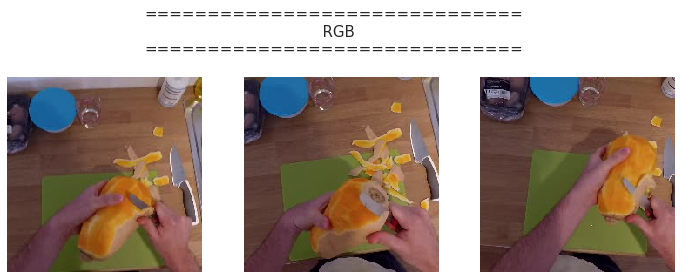

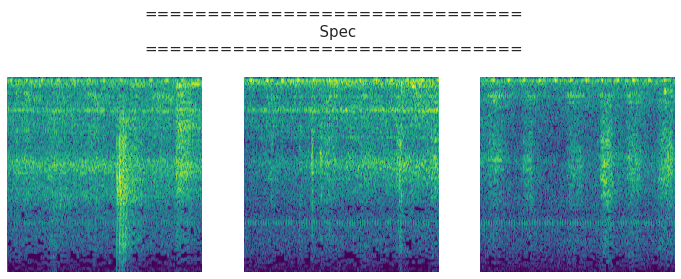

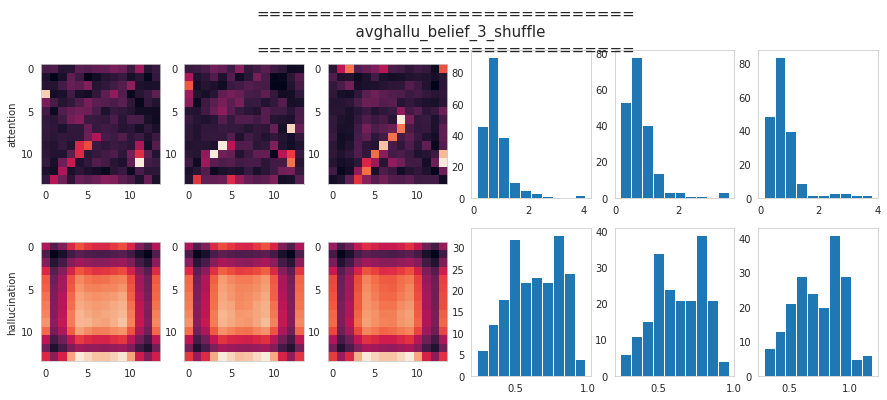

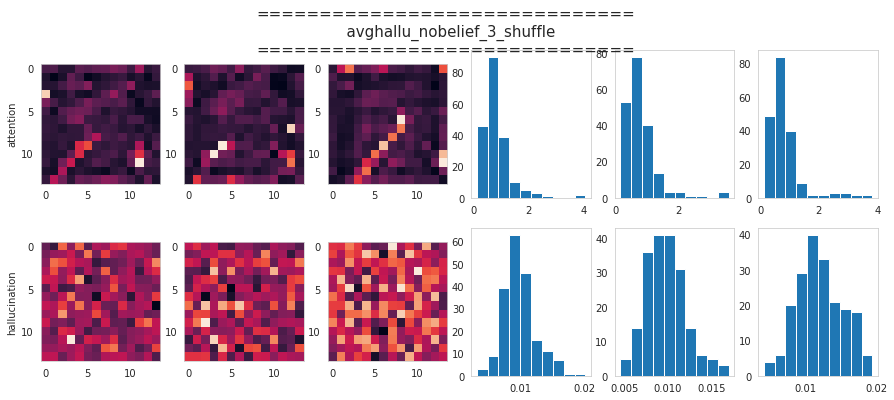

In [4]:
model_cfg = '../configs/model_cfgs/pipeline_rgbspec_san19pairfreeze_avghallu.yaml'
weight = '../saved_models/san19freeze_exp/avghallu_belief_3_shuffle/best.model'
run_experiment(model_cfg, weight, title=weight.split('/')[-2], display=True)

model_cfg = '../configs/model_cfgs/pipeline_rgbspec_san19pairfreeze_avghallu.yaml'
weight = '../saved_models/san19freeze_exp/avghallu_nobelief_3_shuffle/best.model'
run_experiment(model_cfg, weight, title=weight.split('/')[-2])

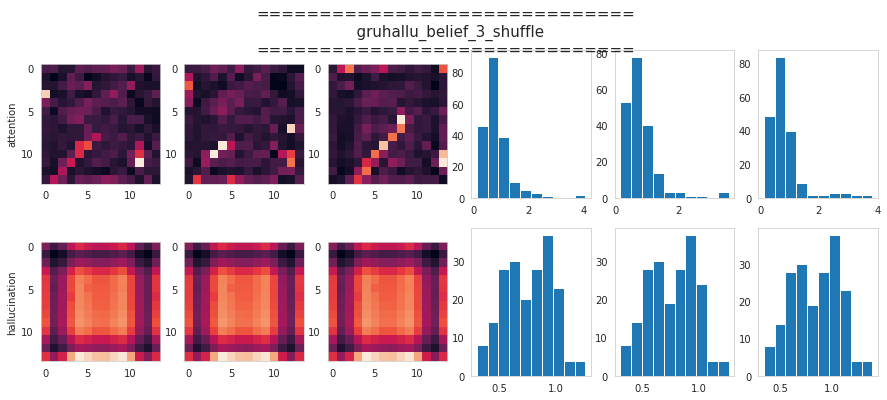

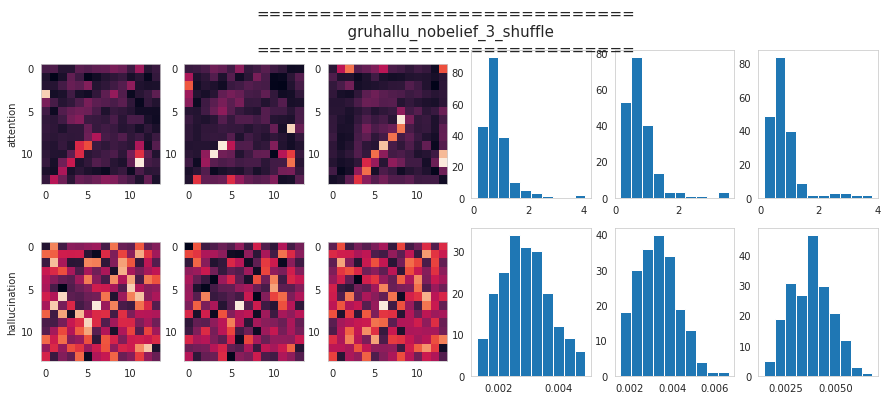

In [5]:
model_cfg = '../configs/model_cfgs/pipeline_rgbspec_san19pairfreeze_gruhallu.yaml'
weight = '../saved_models/san19freeze_exp/gruhallu_belief_3_shuffle/best.model'
run_experiment(model_cfg, weight, title=weight.split('/')[-2])

model_cfg = '../configs/model_cfgs/pipeline_rgbspec_san19pairfreeze_gruhallu.yaml'
weight = '../saved_models/san19freeze_exp/gruhallu_nobelief_3_shuffle/best.model'
run_experiment(model_cfg, weight, title=weight.split('/')[-2])

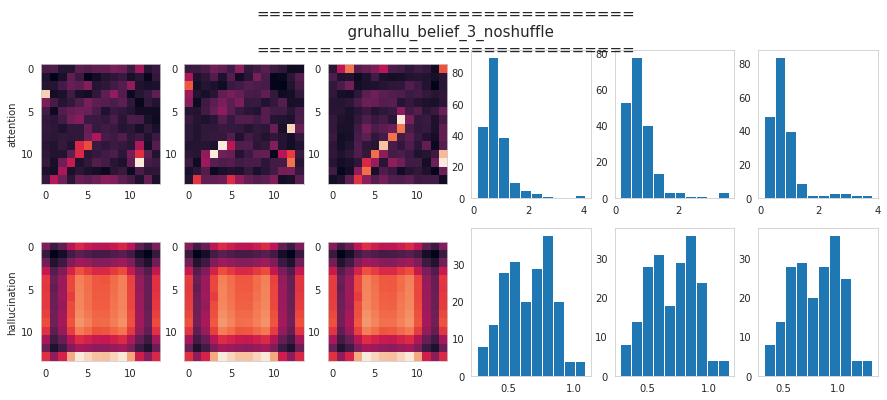

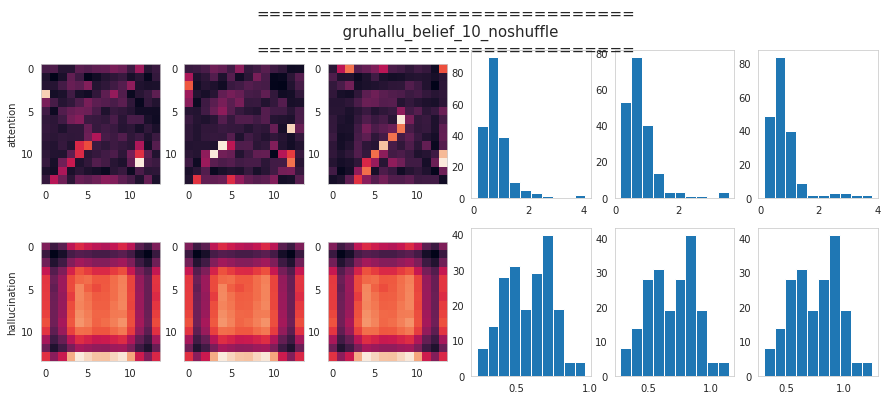

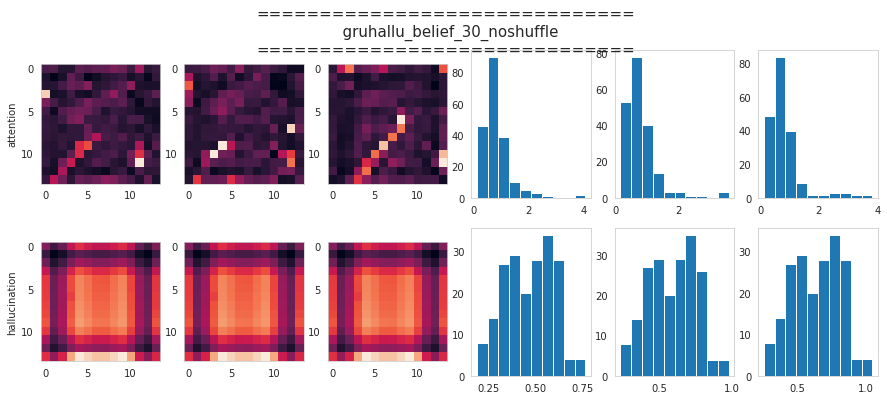

In [6]:
model_cfg = '../configs/model_cfgs/pipeline_rgbspec_san19pairfreeze_gruhallu.yaml'
weight = '../saved_models/san19freeze_exp/gruhallu_belief_3_noshuffle/best.model'
run_experiment(model_cfg, weight, title=weight.split('/')[-2])

# show the 1st 3 frames only
model_cfg = '../configs/model_cfgs/pipeline_rgbspec_san19pairfreeze_gruhallu.yaml'
weight = '../saved_models/san19freeze_exp/gruhallu_belief_10_noshuffle/best.model'
run_experiment(model_cfg, weight, title=weight.split('/')[-2])

# show the 1st 3 frames only
model_cfg = '../configs/model_cfgs/pipeline_rgbspec_san19pairfreeze_gruhallu.yaml'
weight = '../saved_models/san19freeze_exp/gruhallu_belief_30_noshuffle/best.model'
run_experiment(model_cfg, weight, title=weight.split('/')[-2])

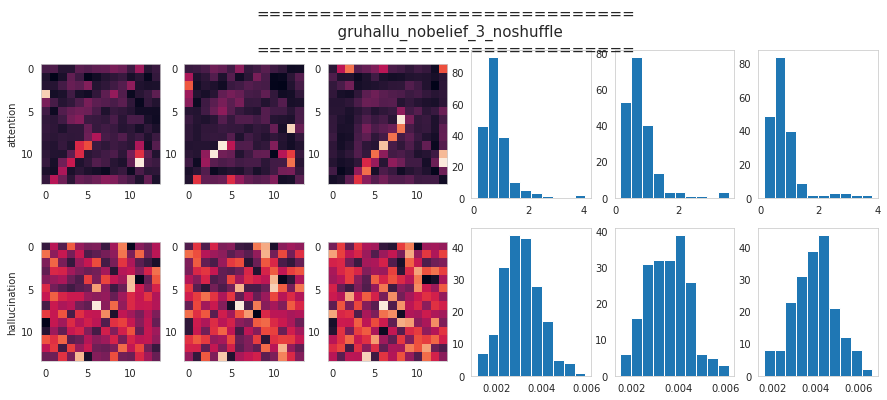

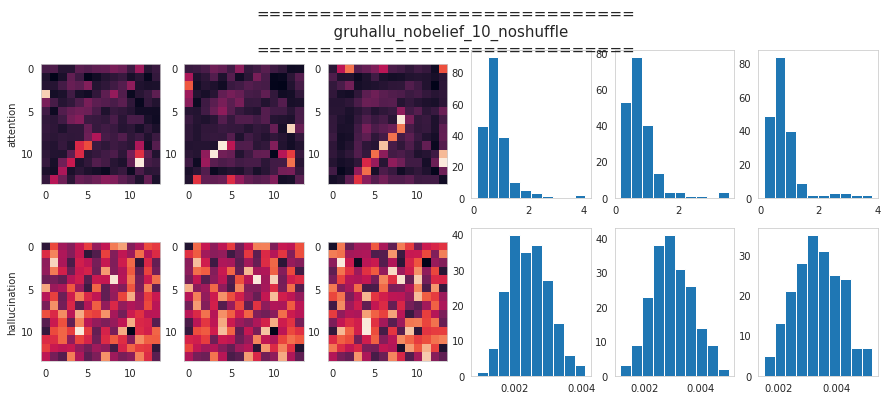

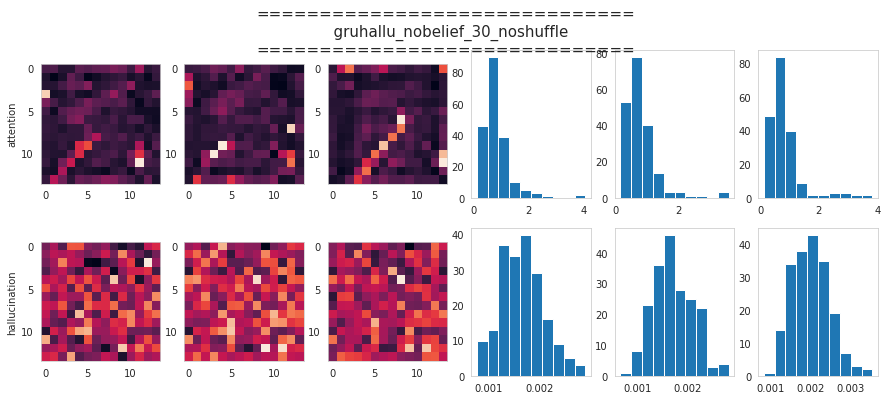

In [7]:
model_cfg = '../configs/model_cfgs/pipeline_rgbspec_san19pairfreeze_gruhallu.yaml'
weight = '../saved_models/san19freeze_exp/gruhallu_nobelief_3_noshuffle/best.model'
run_experiment(model_cfg, weight, title=weight.split('/')[-2])

# show the 1st 3 frames only
model_cfg = '../configs/model_cfgs/pipeline_rgbspec_san19pairfreeze_gruhallu.yaml'
weight = '../saved_models/san19freeze_exp/gruhallu_nobelief_10_noshuffle/best.model'
run_experiment(model_cfg, weight, title=weight.split('/')[-2])

# show the 1st 3 frames only
model_cfg = '../configs/model_cfgs/pipeline_rgbspec_san19pairfreeze_gruhallu.yaml'
weight = '../saved_models/san19freeze_exp/gruhallu_nobelief_30_noshuffle/best.model'
run_experiment(model_cfg, weight, title=weight.split('/')[-2])